## This notebook implements the SSSR method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import io as iot
import sys
import time
from matplotlib import pyplot
import random
from scipy.signal import convolve2d
from spectral import *
import math 
from collections import deque

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
from tqdm import tqdm
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import torch.utils.data as data
from fvcore.nn import FlopCountAnalysis, parameter_count_table

2025-07-12 22:49:22.227995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 22:49:22.249060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 22:49:22.267082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 22:49:22.271890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 22:49:22.285570: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Checking GPU usage

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("No GPU found for TensorFlow. Using CPU.")


if torch.cuda.is_available():
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU found for PyTorch. Using CPU.")

TensorFlow is using the following GPU(s):
 - /physical_device:GPU:0
PyTorch is using GPU: NVIDIA A100-SXM4-80GB


In [3]:
# For TensorFlow
def set_random_seed_tf(seed=42):
    """
    Sets the random seed for reproducibility in TensorFlow, NumPy, and Python.
    Also sets TF deterministic ops.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Optional: Force deterministic operations
    try:
        tf.config.experimental.enable_op_determinism()
    except AttributeError:
        # Older TF version fallback
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        
set_random_seed_tf(42)

# For PyTorch
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Helper Functions

In [4]:
# Function to downsample an image by a given factor
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image

# Function to downsample an image to a reference shape
def downsample_to_shape(image, target_height, target_width):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Initialize a list to hold the resized channels
    resized_channels = []

    # Resize each channel individually
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        resized_channel = cv2.resize(channel, (target_width, target_height), interpolation=cv2.INTER_AREA)
        resized_channels.append(resized_channel)

    # Stack the resized channels back together
    resized_image = np.stack(resized_channels, axis=-1)

    return resized_image

# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

In [5]:
band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)

In [6]:
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [7]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [8]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [9]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [10]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [11]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_image = normalize(hsi_patch_1)
RGB_1_image = normalize(rgb_patch_1)

In [12]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_image = normalize(hsi_patch_2)
RGB_2_image = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


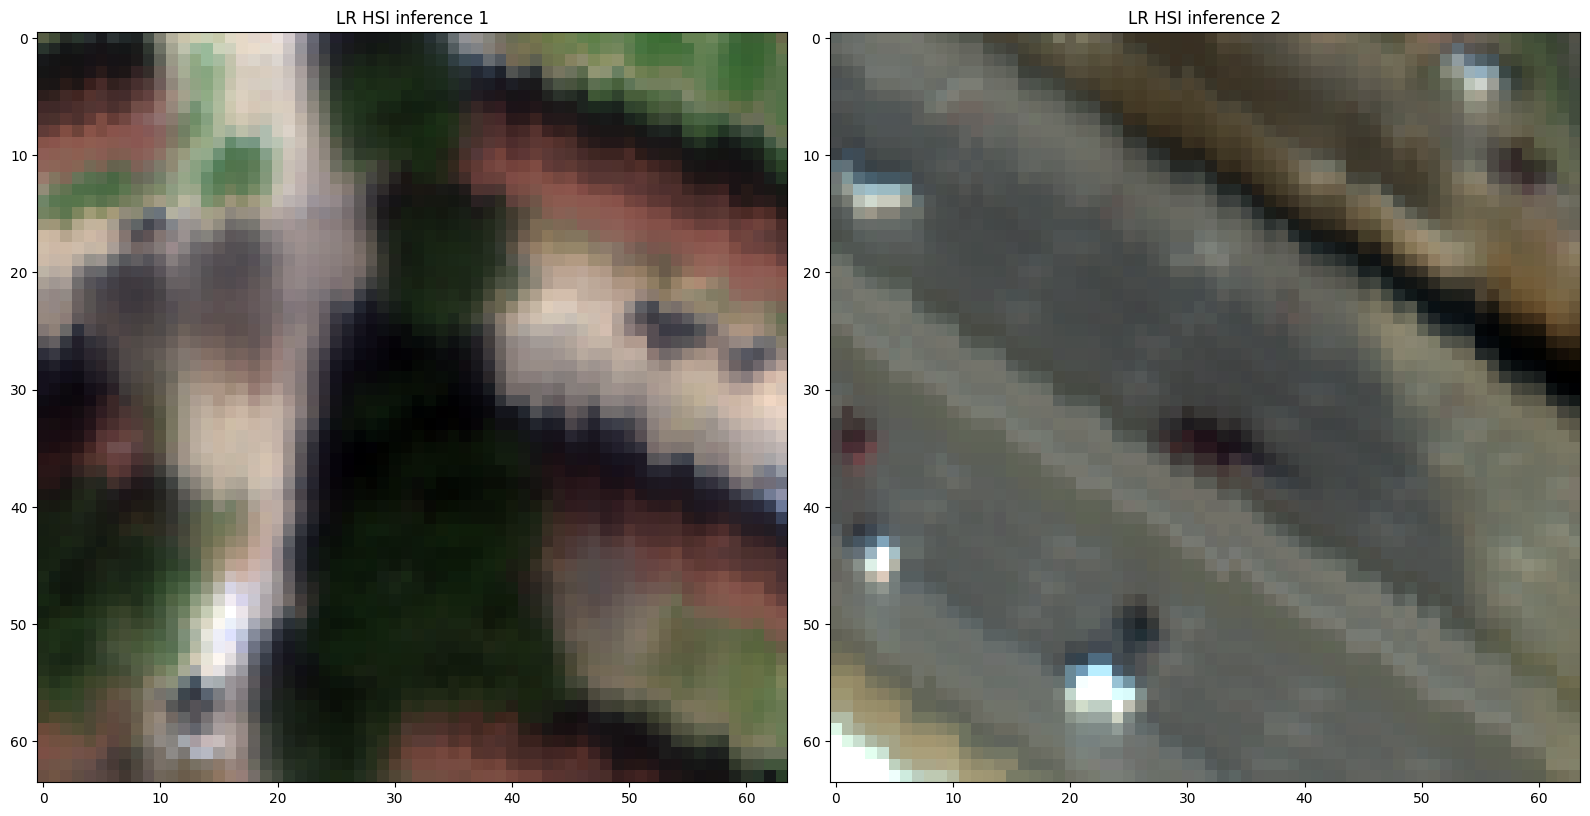

In [13]:
LR_HSI_test_1 = hsi_1_image
print("UH Hyperspectral image 1 inference shape: ", hsi_1_image.shape)

LR_HSI_test_2 = hsi_2_image
print("UH Hyperspectral image 2 inference shape: ", hsi_1_image.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


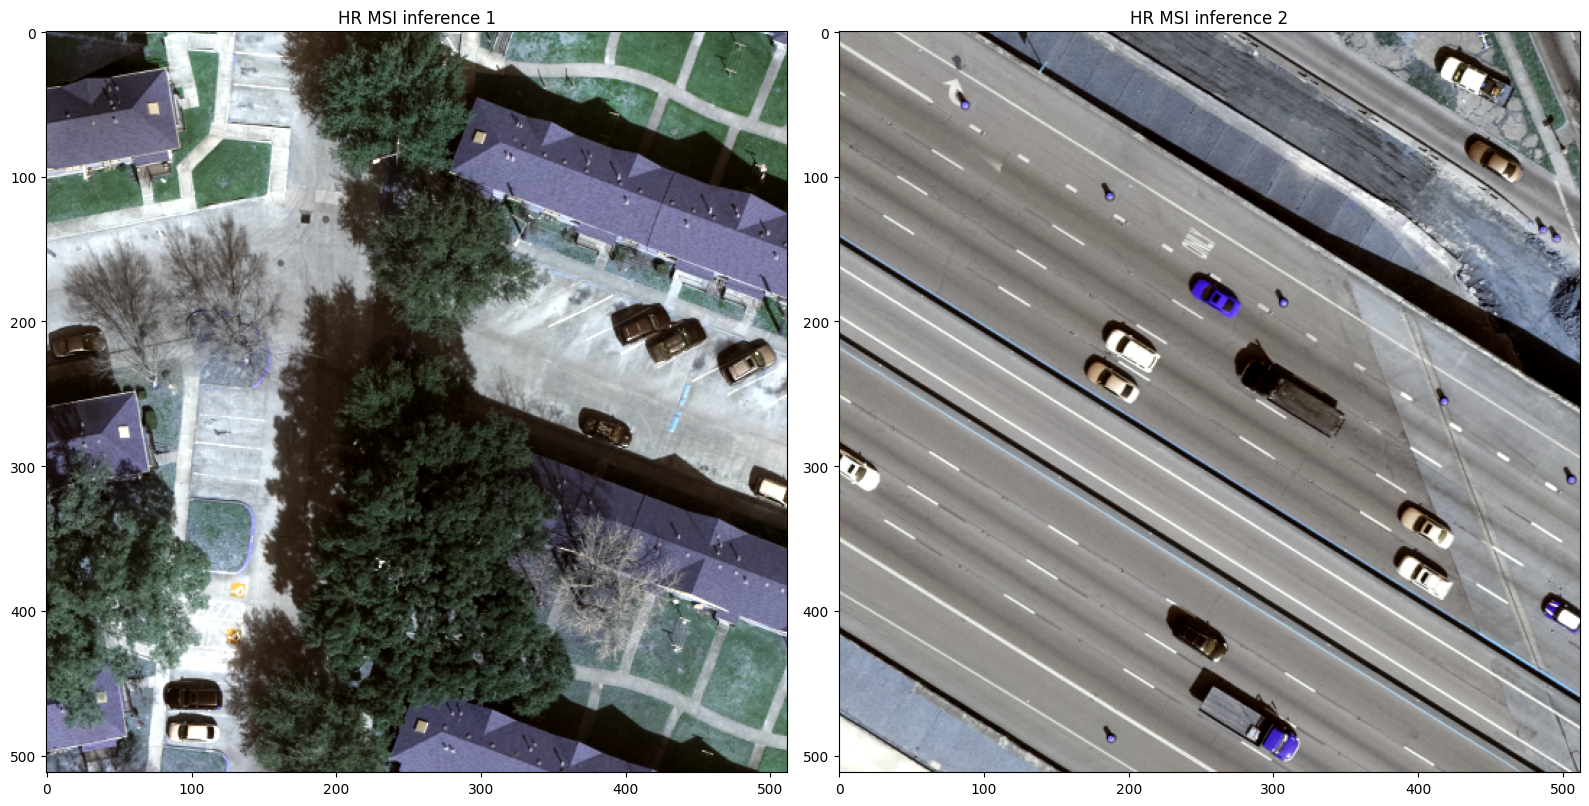

In [14]:
HR_MSI_test_1 = RGB_1_image
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_image
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

SSSR: Self-supervised spectral super-resolution for a fast hyperspectral and multispectral image fusion implementation from their GitHub

In [15]:
def apply_psf(channel, psf):
    """
    Convolve a single channel 2D image with PSF using 'same' padding.

    Parameters:
    -----------
    channel : np.ndarray
        Shape (height, width).
    psf : np.ndarray
        Shape (kernel_height, kernel_width).

    Returns:
    --------
    blurred_channel : np.ndarray
        Same shape as input channel (height, width).
    """
    return convolve2d(channel, psf, mode='same')

def numpy_to_tf(np_array):
    
    """
    Converts a numpy array into a tensorflow tensor.
    """
    
    tf_tensor = tf.constant(np_array, dtype=tf.float32)
    return tf_tensor

def tf_to_numpy(tf_tensor):
    
    """
    Converts a tensorflow tensor into a numpy array.
    """
    
    np_array = tf_tensor.numpy()
    return np_array

In [16]:
class BlurDownBlind(object):
    def __init__(self, shift_h=0, shift_w=0, stride=0):
        self.shift_h = shift_h
        self.shift_w = shift_w
        self.stride = stride
        pass

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups, ratio):
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)
        if self.stride == 0:
            output_tensor = fun.conv2d(input_tensor, psf, None, (1, 1), (pad, pad), groups=groups)
            output_tensor = output_tensor[:, :, self.shift_h:: ratio, self.shift_h:: ratio]
        else:
            output_tensor = fun.conv2d(input_tensor, psf, None, (ratio, ratio), (pad, pad), groups=groups)
        return output_tensor
    
class torchkits(object):
    @staticmethod
    def extract_patches(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        all_patches = input_tensor.unfold(2, kernel, stride).unfold(3, kernel, stride)
        N, C, H, W, h, w = all_patches.shape
        all_patches = all_patches.permute(0, 2, 3, 1, 4, 5)
        all_patches = torch.reshape(all_patches, shape=(N * H * W, C, h, w))
        return all_patches

    @staticmethod
    def torch_norm(input_tensor: torch.Tensor, mode=1):
        if mode == 1:
            loss = torch.sum(torch.abs(input_tensor))
            return loss
        return None

class BlindNet(nn.Module):
    def __init__(self, hs_bands, ms_bands, ker_size, ratio):
        super().__init__()
        self.hs_bands = hs_bands
        self.ms_bands = ms_bands
        self.ker_size = ker_size
        self.ratio = ratio
        self.pad_num = int((self.ker_size - 1) / 2)
        
        psf = torch.ones([1, 1, self.ker_size, self.ker_size]) * (1.0 / (self.ker_size ** 2))
        self.psf = nn.Parameter(psf)
        
        srf = torch.ones([self.ms_bands, self.hs_bands, 1, 1]) * (1.0 / self.hs_bands)
        self.srf = nn.Parameter(srf)
        
        self.blur_down = BlurDownBlind(stride=0) 

    def forward(self, Y, Z):
        srf_div = torch.sum(self.srf, dim=1, keepdim=True)
        srf_div = torch.div(1.0, srf_div)
        srf_div = torch.transpose(srf_div, 0, 1)  # 1 x l x 1 x 1

        Ylow = fun.conv2d(Y, self.srf, None)
        Ylow = torch.mul(Ylow, srf_div)
        Ylow = torch.clamp(Ylow, 0.0, 1.0)

        Zlow = self.blur_down(Z, self.psf, self.pad_num, self.ms_bands, self.ratio)
        Zlow = torch.clamp(Zlow, 0.0, 1.0)

        return Ylow, Zlow

    def check_weight(model):
        if hasattr(model, 'psf'):
            w = model.psf.data
            w.clamp_(0.0, 1.0)
            psf_div = torch.sum(w)
            psf_div = torch.div(1.0, psf_div)
            w.mul_(psf_div)
        if hasattr(model, 'srf'):
            w = model.srf.data
            w.clamp_(0.0, 10.0)
            srf_div = torch.sum(w, dim=1, keepdim=True)
            srf_div = torch.div(1.0, srf_div)
            w.mul_(srf_div)
    
def train_blindnet(LR_LR_HSI, LR_MSI, ratio=8, max_iter=5000, verbose=True):
    hs_bands = LR_LR_HSI.shape[1]
    ms_bands = LR_MSI.shape[1]
    ker_size = 2 * ratio - 1
    out_h = LR_LR_HSI.shape[2]  # h
    out_w = LR_LR_HSI.shape[3]  # w

    model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-6)

    LR_LR_HSI = LR_LR_HSI.to(device)
    LR_MSI = LR_MSI.to(device)

    pbar = tqdm(range(max_iter), desc="Blind PSF/SRF Estimation", dynamic_ncols=True, ncols=80, leave=True)
    for epoch in pbar:
        model.train()
        Ylow, Zlow = model(LR_LR_HSI, LR_MSI)
        loss = torch.sum(torch.abs(Ylow - Zlow))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.check_weight()

        pbar.set_postfix(loss=f"{loss.item():.6f}")

    pbar.close()

    psf_est = model.psf.detach().cpu().numpy().squeeze()
    srf_est = model.srf.detach().cpu().numpy().squeeze()
    return psf_est, srf_est

In [17]:
def plot_psf_srf(psf_est, srf_est):
    """
    Plot PSF as heatmap and SRF as curves.

    Args:
        psf_est: (kH, kW) numpy array
        srf_est: (ms_bands, hs_bands) numpy array
    """
    ms_bands, hs_bands = srf_est.shape

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot PSF ---
    ax = axs[0]
    im = ax.imshow(psf_est, cmap='viridis')
    ax.set_title('Estimated PSF')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # --- Plot SRF ---
    ax = axs[1]
    x = np.arange(hs_bands)
    for i in range(ms_bands):
        ax.plot(x, srf_est[i], label=f'MSI Band {i+1}')
    ax.set_title('Estimated SRF (Spectral Curves)')
    ax.set_xlabel('HSI Band Index')
    ax.set_ylabel('Relative Response')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [18]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

In [19]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [20]:
def get_gpu_memory_mb():
    """Returns current GPU memory usage (in MB) for GPU:0 using TensorFlow."""
    mem_info = tf.config.experimental.get_memory_info('GPU:0')
    return mem_info['current'] / (1024 ** 2)  # bytes → MB

def infer_and_analyze_model_performance_tf(model, sample_inputs):
    """
    Analyzes model complexity: FLOPs, parameters, inference time, and GPU memory usage.
    
    Parameters:
    - model (tf.keras.Model): The model to evaluate.
    - sample_inputs (list of tf.Tensor): List of input tensors matching the model's expected input.
    """
    # 1) Convert sample_inputs into a concrete function
    sample_input = sample_inputs[:1]  # Shape (1, C_msi)

    # Properly trace the model using a callable
    @tf.function
    def model_fn(msi):
        return model(msi)

    concrete_func = model_fn.get_concrete_function(sample_input)

    # 2) Freeze the graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # 3) Compute FLOPs
    try:
        original_stdout = sys.stdout
        sys.stdout = iot.StringIO()

        with tf.Graph().as_default() as graph:
            tf.compat.v1.import_graph_def(graph_def, name="")
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            opts["output"] = "none"
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                options=opts
            ).total_float_ops
    finally:
        sys.stdout = original_stdout

    # 4) Count parameters and record starting GPU memory
    num_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    start_mem = get_gpu_memory_mb()

    # 5) Time inference
    start = time.perf_counter()
    SR_image = model(sample_inputs)
    end = time.perf_counter()
    inference_time = end - start

    # 6) GPU memory
    end_mem = get_gpu_memory_mb()
    mem_used = end_mem - start_mem

    # 7) Print results
    print(f"Parameters:      {num_params:,}")
    print(f"FLOPs:           {flops:,}")
    print(f"GPU Memory:      {mem_used:.2f} MB")
    print(f"Inference time:  {inference_time:.4f} sec")

    return SR_image

In [21]:
# ----------------------- Custom PReLU -----------------------
class PReLU(Layer):
    def __init__(self, alpha_initializer=tf.constant_initializer(0.25), **kwargs):
        super(PReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.alpha_initializer,
                                     name='alpha',
                                     dtype=tf.float32)
        super(PReLU, self).build(input_shape)
    def call(self, inputs):
        return tf.maximum(0.0, inputs) + self.alpha * tf.minimum(0.0, inputs)

In [22]:
def prepare_hsi_msi_data(HR_MSI, LR_HSI, psf, scale):
    """
    Prepares mrdata and lrdata exactly like the original framework.

    Parameters:
    -----------
    HR_MSI : np.ndarray
        High-resolution multispectral image (H, W, Cₘ).
    LR_HSI : np.ndarray
        Low-resolution hyperspectral image (H/s, W/s, Cₕ).
    psf : np.ndarray
        Point Spread Function kernel (k, k).
    scale : int
        Downsampling factor.

    Returns:
    --------
    mrdata : np.ndarray
        Flattened MSI data (N, Cₘ).
    lrdata : np.ndarray
        Flattened HSI data (N, Cₕ).
    """
    H_hr, W_hr, C_msi = HR_MSI.shape
    H_lr, W_lr, C_hsi = LR_HSI.shape

    # Initialize flattened arrays
    N = H_lr * W_lr
    mrdata = np.zeros((N, C_msi), dtype=np.float32)
    lrdata = np.zeros((N, C_hsi), dtype=np.float32)

    # Blur each HR_MSI channel separately and downsample
    temp = np.zeros((H_hr, W_hr, C_msi), dtype=np.float32)
    for c in range(C_msi):
        temp[:, :, c] = apply_psf(HR_MSI[:, :, c], psf)  # Convolve one channel

    # Downsample using offset like original code
    row_idx = np.int32(np.arange(np.ceil(scale / 2), H_hr, scale))
    col_idx = np.int32(np.arange(np.ceil(scale / 2), W_hr, scale))
    temp_ds = temp[np.ix_(row_idx, col_idx, np.arange(C_msi))]  # (H_lr, W_lr, Cₘ)

    # Fill lrdata and mrdata using nested loops (like original)
    count = 0
    for i in range(H_lr):
        for j in range(W_lr):
            lrdata[count, :] = LR_HSI[i, j, :]       # LR_HSI spectrum
            mrdata[count, :] = temp_ds[i, j, :]      # HR_MSI spectrum
            count += 1

    lrdata = numpy_to_tf(lrdata)
    mrdata = numpy_to_tf(mrdata)

    return mrdata, lrdata

In [23]:
def train_hsi_msi_model(mrdata, lrdata, epochs=2500, learning_rate=0.001):
    """
    Trains HSI-MSI fusion model using raw TensorFlow.

    Parameters:
    -----------
    mrdata : tf.Tensor
        Flattened MSI data (N, Cₘ). Already a tf.Tensor.
    lrdata : tf.Tensor
        Flattened HSI data (N, Cₕ). Already a tf.Tensor.
    epochs : int
        Number of training epochs.
    learning_rate : float
        Adam optimizer learning rate.

    Returns:
    --------
    model : tf.keras.Model
        Trained fusion model.
    """
    C_msi = mrdata.shape[1]
    C_hsi = lrdata.shape[1]

    # Build Model
    msi_input = tf.keras.Input(shape=(C_msi,), name="msi_input")
    x = layers.Dense(units=int(C_hsi / 3), activation=PReLU())(msi_input)
    x = layers.Dense(units=int(2 * C_hsi / 3), activation=PReLU())(x)
    hsi_output = layers.Dense(units=C_hsi, activation=PReLU(), name="hsi_output")(x)
    model = tf.keras.Model(inputs=[msi_input], outputs=[hsi_output])

    # Optimizer and loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Full-batch gradient descent
    start_time = time.perf_counter()
    
    with tqdm(range(epochs), desc="Training Epochs") as pbar:
        for epoch in pbar:
            with tf.GradientTape() as tape:
                predictions = model(mrdata, training=True)
                loss = loss_fn(lrdata, predictions)
    
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
            # Update progress bar postfix with live loss
            pbar.set_postfix(loss=f"{loss.numpy():.6f}")

    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f"Training completed in {total_time: .2f} seconds")

    return model

In [24]:
def run_pipeline(HR_MSI, LR_HSI, psf, scale):
    """
    Runs the full model pipeline
    """

    mrdata, lrdata = prepare_hsi_msi_data(
        HR_MSI=HR_MSI,
        LR_HSI=LR_HSI,
        psf=psf,
        scale=scale
    )

    trained_model = train_hsi_msi_model(mrdata, lrdata, epochs=2500)

    # Original authors way to flatten
    H, W, C_msi = HR_MSI.shape
    mrdatainput = np.zeros((H * W, C_msi), dtype=np.float32)
    count = 0
    for i in range(H):
        for j in range(W):
            mrdatainput[count, :] = HR_MSI[i, j, :]
            count += 1

    mrdatainput = numpy_to_tf(mrdatainput)
    
    impred = infer_and_analyze_model_performance_tf(trained_model, mrdatainput)
    impred = tf_to_numpy(impred)

    H, W = HR_MSI.shape[:2]
    C_hsi = impred.shape[1]
    SR_HSI = np.zeros((H, W, C_hsi), dtype=np.float32)
    count = 0
    for i in range(H):
        for j in range(W):
            SR_HSI[i, j, :] = impred[count, :]
            count += 1

    return SR_HSI

Output file to save super-resolved images

In [25]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/SSSR"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_sssr_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_sssr_folder_path):
    os.makedirs(uh_sssr_folder_path)

Super resolving UH image 1 

Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::mul encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 375
Total FLOPs (1× forward): 177,561,600


Blind PSF/SRF Estimation: 100%|██████████| 5000/5000 [00:14<00:00, 334.95it/s, loss=1701.258301]


Blind training took 16.4s
Peak GPU memory during training: 13.8 MB


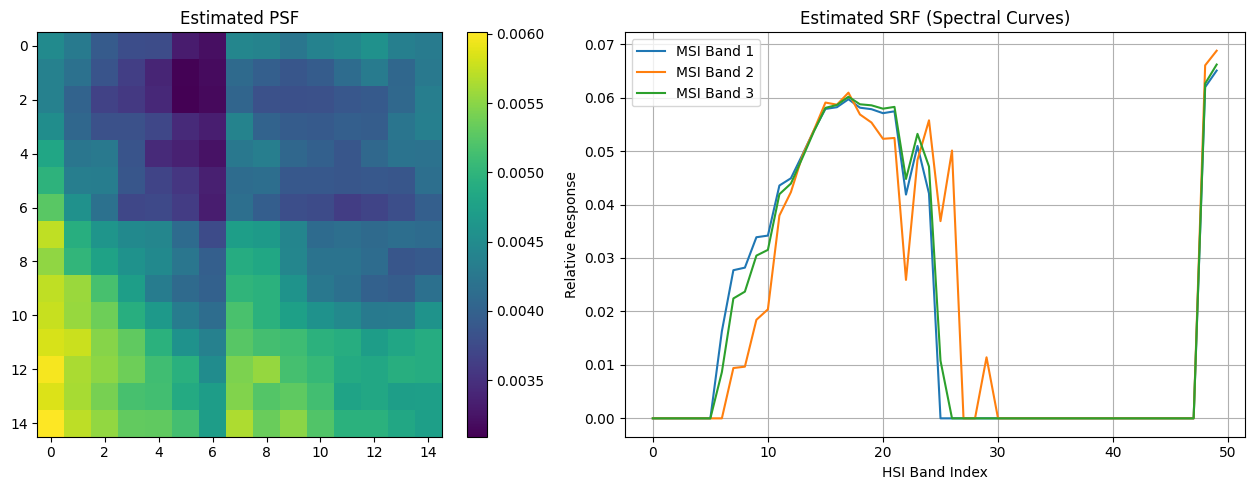

In [26]:
ratio = 8

# 1) Figure out your shapes & bands
H_lr, W_lr, hs_bands = LR_HSI_test_1.shape
H_hr, W_hr, ms_bands = HR_MSI_test_1.shape
ker_size = 2 * ratio - 1  # whatever ratio you chose

# 2) Build input tensors
LR_HSI_tensor = (
    torch.from_numpy(LR_HSI_test_1)
         .permute(2,0,1)          # (C_hsi, H_lr, W_lr)
         .unsqueeze(0)            # (1, C_hsi, H_lr, W_lr)
         .float()
         .to(device)
)
HR_MSI_tensor = (
    torch.from_numpy(HR_MSI_test_1)
         .permute(2,0,1)          # (C_msi, H_hr, W_hr)
         .unsqueeze(0)            # (1, C_msi, H_hr, W_hr)
         .float()
         .to(device)
)

# 3) Instantiate and eval
blind_model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
blind_model.eval()

# 4) Count params
total_params_blind = sum(
    p.numel() for p in blind_model.parameters() if p.requires_grad
)
print(f"Total parameters in blind model: {total_params_blind:,}")

# 5) Compute FLOPs for one forward
#    Use the same shapes actually fed in:
dummy_Y = torch.randn(1, hs_bands, H_lr, W_lr, device=device)
dummy_Z = torch.randn(1, ms_bands, H_hr, W_hr, device=device)
flops_blind = FlopCountAnalysis(blind_model, (dummy_Y, dummy_Z)).total()
print(f"Total FLOPs (1× forward): {flops_blind:,}")

# 6) Measure peak GPU memory during training
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()

# run blind training (this will internally step and clamp)
psf_est, srf_est = train_blindnet(
    LR_HSI_tensor,
    HR_MSI_tensor,
    ratio=ratio,
    max_iter=5000
)

peak_bytes = torch.cuda.max_memory_allocated(device)
peak_mb    = peak_bytes / 1024**2

end_time = time.time()
print(f"Blind training took {end_time - start_time:.1f}s")
print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

# 7) Finally, plot the estimated PSF and SRF
plot_psf_srf(psf_est, srf_est)

In [27]:
SR_image_1 = run_pipeline(HR_MSI_test_1, LR_HSI_test_1, psf=psf_est, scale=8)

print("SR image shape: ", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_sssr_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved Super Resolved HSI 1 at location specified in uh_sssr_folder_path")

2025-07-12 22:49:56.042256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79088 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:cd:00.0, compute capability: 8.0
Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 36.05it/s, loss=0.004381]


Training completed in  69.35 seconds
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


I0000 00:00:1752360667.518772  367953 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-12 22:51:07.518893: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-12 22:51:07.526879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79088 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:cd:00.0, compute capability: 8.0


Parameters:      2,424
FLOPs:           4,947
GPU Memory:      50.00 MB
Inference time:  0.0034 sec
SR image shape:  (512, 512, 50)
SR image max: 1.5539192
SR image min: -0.09359741
SR image mean: 0.27511525
Saved Super Resolved HSI 1 at location specified in uh_sssr_folder_path


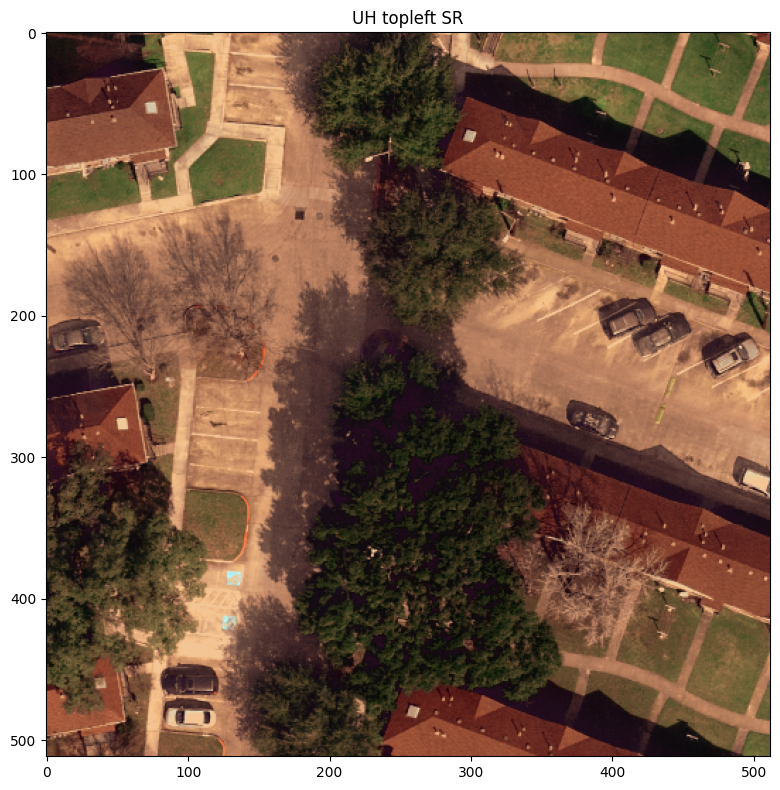

In [28]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

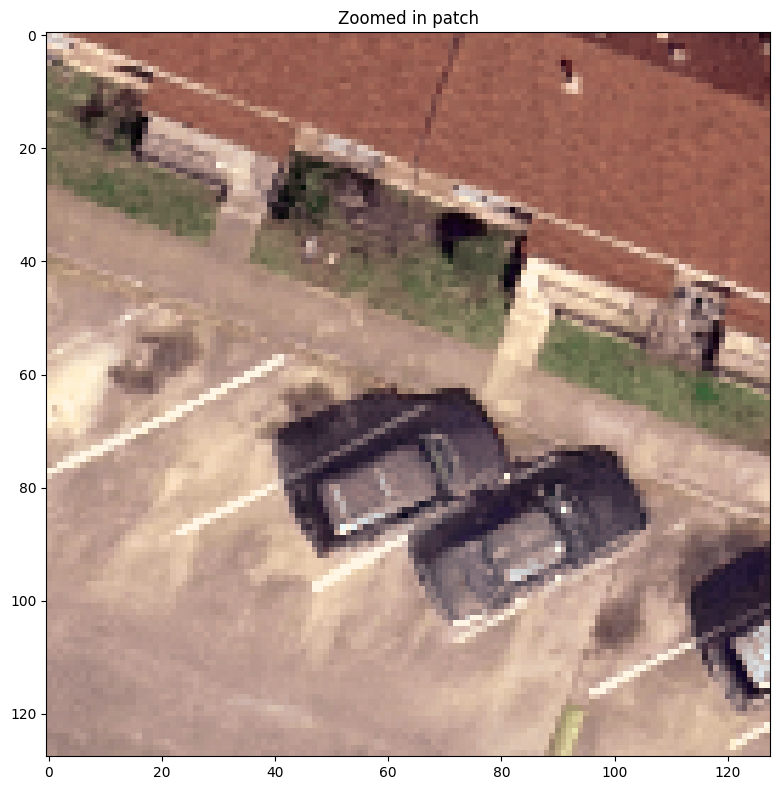

In [29]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::mul encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 375
Total FLOPs (1× forward): 177,561,600


Blind PSF/SRF Estimation: 100%|██████████| 5000/5000 [00:14<00:00, 334.16it/s, loss=809.921021] 


Blind training took 15.0s
Peak GPU memory during training: 13.8 MB


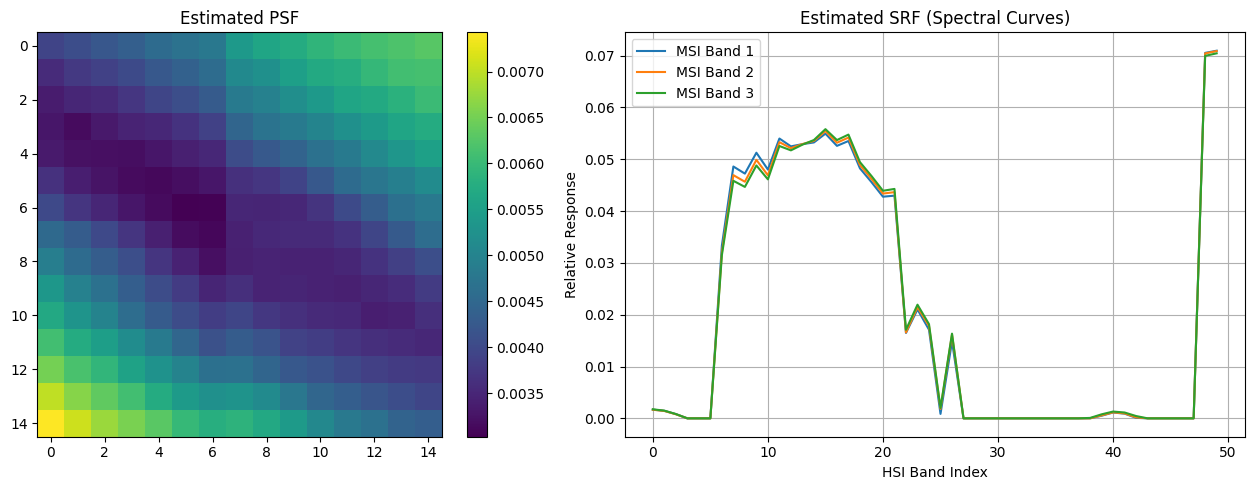

In [30]:
ratio = 8

# 1) Figure out your shapes & bands
H_lr, W_lr, hs_bands = LR_HSI_test_2.shape
H_hr, W_hr, ms_bands = HR_MSI_test_2.shape
ker_size = 2 * ratio - 1  # whatever ratio you chose

# 2) Build input tensors
LR_HSI_tensor = (
    torch.from_numpy(LR_HSI_test_2)
         .permute(2,0,1)          # (C_hsi, H_lr, W_lr)
         .unsqueeze(0)            # (1, C_hsi, H_lr, W_lr)
         .float()
         .to(device)
)
HR_MSI_tensor = (
    torch.from_numpy(HR_MSI_test_2)
         .permute(2,0,1)          # (C_msi, H_hr, W_hr)
         .unsqueeze(0)            # (1, C_msi, H_hr, W_hr)
         .float()
         .to(device)
)

# 3) Instantiate and eval
blind_model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
blind_model.eval()

# 4) Count params
total_params_blind = sum(
    p.numel() for p in blind_model.parameters() if p.requires_grad
)
print(f"Total parameters in blind model: {total_params_blind:,}")

# 5) Compute FLOPs for one forward
#    Use the same shapes actually fed in:
dummy_Y = torch.randn(1, hs_bands, H_lr, W_lr, device=device)
dummy_Z = torch.randn(1, ms_bands, H_hr, W_hr, device=device)
flops_blind = FlopCountAnalysis(blind_model, (dummy_Y, dummy_Z)).total()
print(f"Total FLOPs (1× forward): {flops_blind:,}")

# 6) Measure peak GPU memory during training
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()

# run blind training (this will internally step and clamp)
psf_est, srf_est = train_blindnet(
    LR_HSI_tensor,
    HR_MSI_tensor,
    ratio=ratio,
    max_iter=5000
)

peak_bytes = torch.cuda.max_memory_allocated(device)
peak_mb    = peak_bytes / 1024**2

end_time = time.time()
print(f"Blind training took {end_time - start_time:.1f}s")
print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

# 7) Finally, plot the estimated PSF and SRF
plot_psf_srf(psf_est, srf_est)

In [ ]:
SR_image_2 = run_pipeline(HR_MSI_test_2, LR_HSI_test_2, psf=psf_est, scale=8)

print("SR image shape: ", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# Full file path (including the file name and extension)
file_path = f"{uh_sssr_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved Super Resolved HSI 2 at location specified in uh_sssr_folder_path")

Training Epochs:  52%|█████▏    | 1295/2500 [00:35<00:32, 37.07it/s, loss=0.004002]

In [ ]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

In [ ]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")